<a href="https://colab.research.google.com/github/kathniev-source/WIDS2021/blob/main/WiDS2021_baselinev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the Libraries


In [ ]:
import pandas as pd
import numpy as np


import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import os
from tqdm.notebook import tqdm
import gc
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OrdinalEncoder



from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics


#import shap
#shap.initjs()

Set display option none

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Load the Data

In [ ]:
TARGET_COL = "diabetes_mellitus"
df = pd.read_csv("/content/drive/MyDrive/WiDS2021/TrainingWiDS2021.csv")
print(df.shape)
test = pd.read_csv("/content/drive/MyDrive/WiDS2021/UnlabeledWiDS2021.csv")
print(test.shape)

(130157, 181)
(10234, 180)


Joining train and test to ensure encodings done correctly

In [ ]:
df['label']='train'
test['label']='test'
frames = [df,test]
join_df = pd.concat(frames, keys=['x', 'y'])
assert len(join_df) == len(df) + len(test)


We can use the following code to delete certain colums that are empty more than 80%

In [ ]:
lst = join_df.isna().sum()/len(join_df)
p = pd.DataFrame(lst)
p.reset_index(inplace=True)
p.columns = ['a','b']
low_count = p[p['b']>0.8]
todelete=low_count['a'].values

In [ ]:
todelete

array(['h1_diasbp_invasive_max', 'h1_diasbp_invasive_min',
       'h1_mbp_invasive_max', 'h1_mbp_invasive_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_albumin_max',
       'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min',
       'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min',
       'h1_creatinine_max', 'h1_creatinine_min', 'h1_hco3_max',
       'h1_hco3_min', 'h1_lactate_max', 'h1_lactate_min',
       'h1_platelets_max', 'h1_platelets_min', 'h1_wbc_max', 'h1_wbc_min',
       'h1_arterial_pco2_max', 'h1_arterial_pco2_min',
       'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max',
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max',
       'h1_pao2fio2ratio_min'], dtype=object)

In [ ]:
join_df.drop(todelete,axis=1,inplace=True)

In [ ]:
join_df.describe

In [ ]:
join_df.head()

Unnamed: 0  encounter_id  hospital_id   age        bmi  elective_surgery  \
x 0           1        214826          118  68.0  22.732803                 0   
  1           2        246060           81  77.0  27.421875                 0   
  2           3        276985          118  25.0  31.952749                 0   
  3           4        262220          118  81.0  22.635548                 1   
  4           5        201746           33  19.0        NaN                 0   

     ethnicity gender  height hospital_admit_source  \
x 0  Caucasian      M   180.3                 Floor   
  1  Caucasian      F   160.0                 Floor   
  2  Caucasian      F   172.7  Emergency Department   
  3  Caucasian      F   165.1        Operating Room   
  4  Caucasian      M   188.0                   NaN   

              icu_admit_source  icu_id icu_stay_type      icu_type  \
x 0                      Floor      92         admit         CTICU   
  1                      Floor      90         admit  Med-Surg ICU   
  2       Accident & Emergency      93         admit  Med-Surg ICU   
  3  Operating Room / Recovery      92         admit         CTICU   
  4       Accident & Emergency      91         admit  Med-Surg ICU   

     pre_icu_los_days  readmission_status  weight  albumin_apache  \
x 0          0.541667                   0    73.9             2.3   
  1          0.927778                   0    70.2             NaN   
  2          0.000694                   0    95.3             NaN   
  3          0.000694                   0    61.7             NaN   
  4          0.073611                   0     NaN             NaN   

     apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  \
x 0               113.0               502.01                      0   
  1               108.0               203.01                      0   
  2               122.0               703.03                      0   
  3               203.0              1206.03                      1   
  4               119.0               601.01                      0   

     arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  \
x 0           0               0.4        31.0               2.51          NaN   
  1           0               NaN         9.0               0.56          1.0   
  2           0               NaN         NaN                NaN          NaN   
  3           0               NaN         NaN                NaN          0.6   
  4           0               NaN         NaN                NaN          NaN   

     gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  \
x 0              3.0               6.0                0.0                4.0   
  1              1.0               3.0                0.0                1.0   
  2              3.0               6.0                0.0                5.0   
  3              4.0               6.0                0.0                5.0   
  4              NaN               NaN                NaN                NaN   

     glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  \
x 0           168.0              118.0               27.4                 0   
  1           145.0              120.0               36.9                 0   
  2             NaN              102.0                NaN                 0   
  3           185.0              114.0               25.9                 1   
  4             NaN               60.0                NaN                 0   

     map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  \
x 0        40.0           NaN                  NaN          NaN        NaN   
  1        46.0          37.0                 37.0         51.0       7.45   
  2        68.0           NaN                  NaN          NaN        NaN   
  3        60.0          30.0                 30.0        142.0       7.39   
  4       103.0           NaN                  NaN          NaN        NaN   

     resprat

To Reduce Memory Usage

In [ ]:
#helps with reducing memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
join_df.drop(['Unnamed: 0','encounter_id','hospital_id'],inplace=True,axis=1)

In [ ]:
def age_group(x):
    
    if x<=50:
        return "0-50"
    elif x>50 and x<=65:
        return "50-65"
    elif x>65 and x<=75:
        return "65-75"
    elif x>75:
        return "75+"

    
def get_bmi_cat(x):
    
    if x<= 18.5:
        return "underweight"
    elif x> 18.5 and x<= 25:
        return "normal"
    elif x> 25 and x<= 30:
        return "overweight"
    elif x> 30 and x<= 35:
        return "obese_class1"
    elif x> 35 and x<= 40:
        return "obese_class2"
    elif x> 40:
        return "obese_class3"

In [ ]:
def _group_feature_eng(combined_df, n_train, group_var, num_feats):
    
    """
    combined_df: the combined train & test datasets.
    n_train: number of training observations
    group_var: the variable we'd like to group by
    num_feat: numerical features
    
    This function loops through all numerical features, 
    group by the variable and compute new statistics of the numerical features.
    """
    
    grouped = combined_df.groupby(group_var)

    for nf in num_feats:

        combined_df[group_var + '_' + nf + '_max'] = grouped[nf].transform('max')
        combined_df[group_var + '_' + nf + '_min'] = grouped[nf].transform('min')
        combined_df[group_var + '_' + nf + '_mean'] = grouped[nf].transform('mean')
        combined_df[group_var + '_' + nf + '_skew'] = grouped[nf].transform('skew')
        combined_df[group_var + '_' + nf + '_std'] = grouped[nf].transform('std')

    train_X = combined_df.iloc[:n_train]
    test_X = combined_df.iloc[n_train:]
    
    return train_X, test_X

In [ ]:
join_df['age_group'] = join_df['age'].apply(age_group)
join_df['bmi_group'] = join_df['bmi'].apply(get_bmi_cat)

In [ ]:
print([c for c in df.columns if (1<df[c].nunique()) & (df[c].dtype != np.number)& (df[c].dtype != int) ])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  """Entry point for launching an IPython kernel.


['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']


In [ ]:
## Print the categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = join_df.select_dtypes(include=numerics)
numeric_cols = newdf.columns

In [ ]:
categorical_cols =  ['elective_surgery','icu_id',
 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type','aids','cirrhosis','hepatic_failure','immunosuppression',
 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','apache_post_operative','arf_apache','fio2_apache','gcs_unable_apache','gcs_eyes_apache',
 'gcs_motor_apache','gcs_verbal_apache','intubated_apache','ventilated_apache','solid_tumor_with_metastasis', 'age_group', 'bmi_group']
for i, v in tqdm(enumerate(categorical_cols)):
    join_df[v] = join_df[v].fillna(join_df[v].value_counts().index[0])

In [ ]:
for i, v in tqdm(enumerate([numeric_cols])):
    join_df[v] =join_df.groupby(['ethnicity','gender'], sort=False)[v].apply(lambda x: x.fillna(x.mean()))

In [ ]:
# In loop to minimize memory use
for i, v in tqdm(enumerate(categorical_cols)):
    join_df[v] = OrdinalEncoder(dtype="int").fit_transform(join_df[[v]])
gc.collect()

33

In [ ]:
join_df.drop(['age','bmi'], axis=1, inplace=True)

In [ ]:
join_df.describe()

,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,age_group,bmi_group
count,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.0,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391.000000,140391

In [ ]:
train = join_df[join_df['label']=="train"]
predict = join_df[join_df['label']=='test']

In [ ]:
train.reset_index(inplace=True)
train.drop(['level_0','level_1','label'],inplace=True,axis =1 )

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train.shape

(130157, 146)

In [ ]:
predict.reset_index(inplace=True)
predict.drop(['level_0','level_1','diabetes_mellitus','label'],inplace=True,axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
predict.shape

(10234, 145)

In [ ]:
features = train.columns

In [ ]:
num_feature = [col for col in features if col not in categorical_cols]

In [ ]:
num_feature = [col for col in features if col not in categorical_cols and train[col].dtype != 'object']
drop_columns=[]
corr = train[num_feature].corr()
# Drop highly correlated features 
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >=0.999 :
            if columns[j]:
                columns[j] = False
                print('FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(train[num_feature].columns[i] , train[num_feature].columns[j], corr.iloc[i,j]))
        elif corr.iloc[i,j] <= -0.995:
            if columns[j]:
                columns[j] = False

FEAT_A: paco2_apache FEAT_B: paco2_for_ph_apache - Correlation: 1.0
FEAT_A: d1_inr_max FEAT_B: h1_inr_max - Correlation: 1.0
FEAT_A: d1_inr_min FEAT_B: h1_inr_min - Correlation: 1.0


In [ ]:
drop_columns = train[num_feature].columns[columns == False].values
print('drop_columns',len(drop_columns),drop_columns)

drop_columns 3 ['paco2_for_ph_apache' 'h1_inr_max' 'h1_inr_min']


In [ ]:
train.drop(drop_columns,inplace=True,axis =1 )

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
predict.drop(drop_columns,inplace=True,axis =1 )

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train[TARGET_COL].value_counts()/len(train)

0.0    0.783715
1.0    0.216285
Name: diabetes_mellitus, dtype: float64

In [ ]:
print(train.shape,predict.shape)

(130157, 143) (10234, 142)


In [ ]:
# Separate majority and minority classes
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
df_majority = train[train['diabetes_mellitus']==0]
df_minority = train[train['diabetes_mellitus']==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=83798,    # to match majority class
                                 random_state= 303) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes_mellitus.value_counts()

0.0    102006
1.0     83798
Name: diabetes_mellitus, dtype: int64

In [ ]:
train = df_upsampled

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     train[[c for c in train if TARGET_COL != c]], train[TARGET_COL], test_size=0.20, random_state=42)
print(X_train.shape,X_test.shape)

(148643, 142) (37161, 142)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape,X_valid.shape)

(118914, 142) (29729, 142)


In [ ]:
X_train.head()

,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,age_group,bmi_group
35572,0,2,1,166.000000,8,2,111,0,6,1.331250,0,80.000000,2.900000,301.0,410.01,0,0,1.295588,18.000000,1.400000,90,3,4,0,1,187.0,98.0,31.300000,0,57.0,42.502610,130.149006,7.352268,25.0,142.000000,36.7,1798.761600,0,9.100000,64.000000,61.000000,81.0,43.0,81.0,43.0,93.0,69.0,95.000000,88.000000,102.0,57.0,102.0,57.0,22.0,14.0,100.0,92.0,149.000000,129.000000,181.0,101.0,181.0,101.0,37.2,36.7,75.819501,63.276207,76.432459,63.860077,91.536017,82.773813,91.365256,79.091880,91.427949,79.504217,22.260312,16.762753,97.961444,95.087143,132.553999,115.283722,132.35556,115.548868,36.728187,36.613176,2.900000,2.900000,1.283309,1.204352,18.000000,18.000000,8.500000,8.500000,1.400000,1.400000,187.0,85.0,23.000000,23.000000,10.900000,10.900000,31.300000,31.300000,1.580286,1.467037,2.871769,2.050638,153.000000,153.00000,3.900000,3.900000,142.000000,142.000000,9.100000,9.100000,164.823373,156.402833,11.551785,11.418027,34.525332,34.077598,4.249610,4.200451,138.246633,137.923187,45.642234,38.656360,7.388727,7.324334,165.471377,100.675776,279.616788,214.076778,0,0,0,0,0,0,0,3,4
124072,0,2,1,182.900000,3,0,349,0,4,-0.035417,0,103.400000,2.932630,110.0,104.01,0,0,0.800000,58.000000,1.600000,90,3,5,0,4,270.0,111.0,38.400000,0,70.0,42.502610,130.149006,7.352268,59.0,136.000000,36.3,1879.826626,0,3.600000,78.181738,46.969257,93.0,51.0,93.0,51.0,104.0,73.0,113.787211,61.977119,105.0,70.0,105.0,70.0,54.0,20.0,95.0,82.0,152.412626,93.664857,136.0,97.0,136.0,97.0,38.0,36.3,64.000000,64.000000,64.000000,64.000000,98.000000,90.000000,86.000000,86.000000,86.000000,86.000000,54.000000,29.000000,95.000000,88.000000,121.000000,121.000000,121.00000,121.000000,38.000000,38.000000,2.998705,2.927717,0.800000,0.800000,58.000000,52.000000,8.600

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
features = X_train.columns

In [ ]:
print(f"accuracy score is {accuracy_score(y_test, rf.predict(X_test))}")
print(classification_report(y_test, rf.predict(X_test), labels=[0, 1]))

accuracy score is 0.9340437555501736
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     20290
           1       0.91      0.95      0.93     16871

    accuracy                           0.93     37161
   macro avg       0.93      0.94      0.93     37161
weighted avg       0.94      0.93      0.93     37161



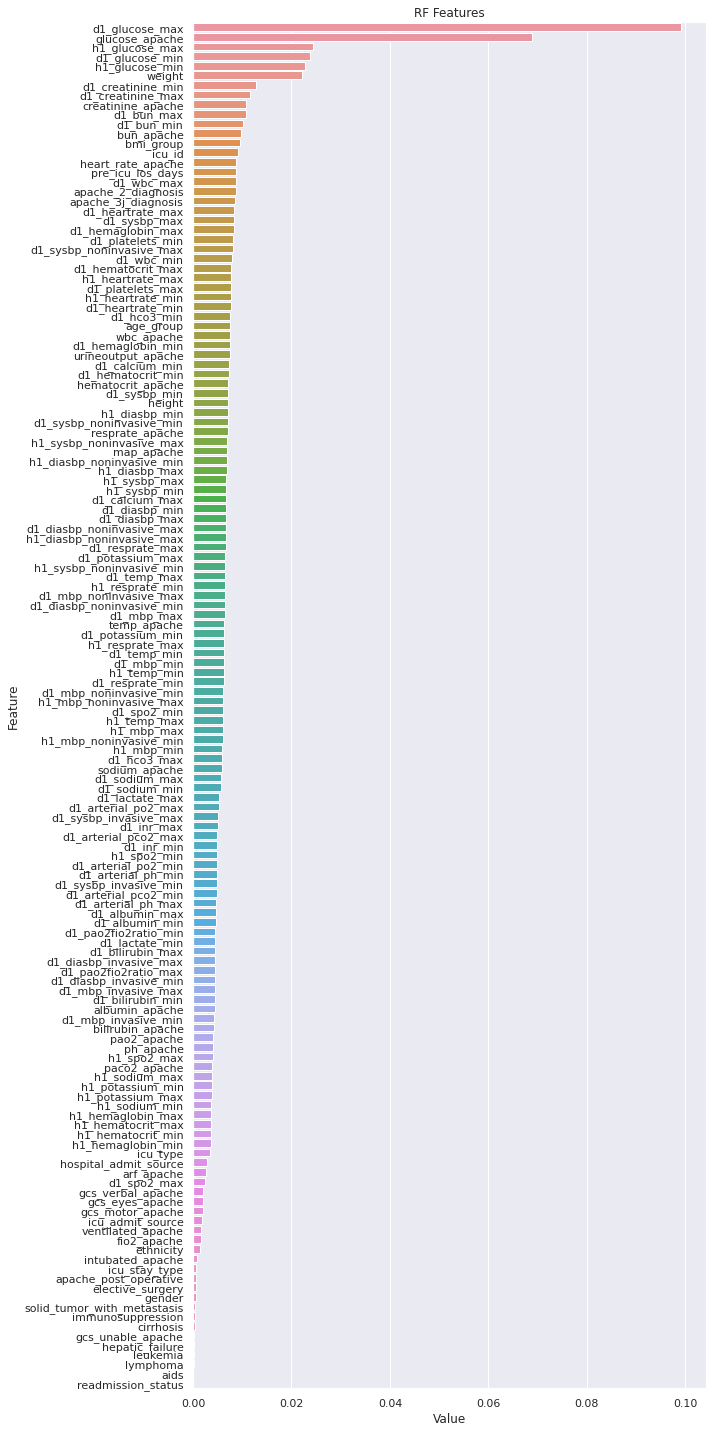

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RF Features')
plt.tight_layout()
plt.show()

In [ ]:
pred = rf.predict_proba(predict)[:,1]
test[TARGET_COL] = pred
df.diabetes_mellitus = df.diabetes_mellitus.round()

In [ ]:
answer = test[["encounter_id","diabetes_mellitus"]]

In [ ]:
answer = answer.round(0)

In [ ]:
answer.diabetes_mellitus = answer.diabetes_mellitus.astype(int)

In [ ]:
answer.to_csv("/content/drive/MyDrive/WiDS2021/submission_baseline1.csv",index=False)

In [ ]:
model = XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print(f"accuracy score is {accuracy_score(y_test, model.predict(X_test))}")
print(metrics.classification_report(y_test, model.predict(X_test), labels=[0, 1]))

accuracy score is 0.7712386641909529
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     20290
           1       0.76      0.73      0.74     16871

    accuracy                           0.77     37161
   macro avg       0.77      0.77      0.77     37161
weighted avg       0.77      0.77      0.77     37161



In [ ]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
print(f"accuracy score is {accuracy_score(y_valid, model.predict(X_valid))}")
print(metrics.classification_report(y_valid, model.predict(X_valid), labels=[0, 1]))

accuracy score is 0.7957886239025866
              precision    recall  f1-score   support

           0       0.82      0.81      0.81     16403
           1       0.77      0.78      0.77     13326

    accuracy                           0.80     29729
   macro avg       0.79      0.79      0.79     29729
weighted avg       0.80      0.80      0.80     29729



In [ ]:
pred = model.predict_proba(predict)[:,1]
test[TARGET_COL] = pred
answer = test[["encounter_id","diabetes_mellitus"]]
answer = answer.round(0)
answer.diabetes_mellitus = answer.diabetes_mellitus.astype(int)
answer.to_csv("/content/drive/MyDrive/WiDS2021/submission_baseline2.csv",index=False)

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
model = LGBMClassifier(
                              random_state=33,
                              early_stopping_rounds = 250,
                              n_estimators=1000,
                              boosting_type='gbdt', num_leaves=151, max_depth=- 1, learning_rate=0.02, subsample_for_bin=200, 
                              min_split_gain=0.5, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, 
                              colsample_bytree=.75, reg_alpha=1.3, reg_lambda=0.1,  n_jobs=- 1,
                              silent=True, importance_type='split')

model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',  
    verbose=False,
)
#{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 20, 'n_estimators': 1000}

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
               early_stopping_rounds=250, importance_type='split',
               learning_rate=0.02, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.5, n_estimators=1000,
               n_jobs=-1, num_leaves=151, objective=None, random_state=33,
               reg_alpha=1.3, reg_lambda=0.1, silent=True, subsample=1.0,
               subsample_for_bin=200, subsample_freq=0)

In [ ]:
print(f"accuracy score is {accuracy_score(y_test, model.predict(X_test))}") #0.02- 0.8423
print(metrics.classification_report(y_test, model.predict(X_test), labels=[0, 1]))

accuracy score is 0.8723931002933183
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     20290
           1       0.84      0.89      0.86     16871

    accuracy                           0.87     37161
   macro avg       0.87      0.87      0.87     37161
weighted avg       0.87      0.87      0.87     37161



In [ ]:
pred = model.predict_proba(predict)[:,1]
test[TARGET_COL] = pred
answer = test[["encounter_id","diabetes_mellitus"]]
answer = answer.round(0)
answer.diabetes_mellitus = answer.diabetes_mellitus.astype(int)
answer.to_csv("/content/drive/MyDrive/WiDS2021/submission_baseline3.csv",index=False)

In [ ]:
model = LGBMClassifier(
                              random_state=33,
                              early_stopping_rounds = 250,
                              n_estimators=1000,
                              boosting_type='gbdt', num_leaves=151, max_depth=- 1, learning_rate=0.02, subsample_for_bin=200, 
                              min_split_gain=0.5, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, 
                              colsample_bytree=.75, reg_alpha=1.3, reg_lambda=0.1,  n_jobs=- 1,
                              silent=True, importance_type='split')

model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',  
    verbose=False,
)
#{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 20, 'n_estimators': 1000}

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
               early_stopping_rounds=250, importance_type='split',
               learning_rate=0.02, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.5, n_estimators=1000,
               n_jobs=-1, num_leaves=151, objective=None, random_state=33,
               reg_alpha=1.3, reg_lambda=0.1, silent=True, subsample=1.0,
               subsample_for_bin=200, subsample_freq=0)

In [ ]:
print(f"accuracy score is {accuracy_score(y_test, model.predict(X_test))}") #0.02- 0.8423
print(metrics.classification_report(y_test, model.predict(X_test), labels=[0, 1]))

accuracy score is 0.8723931002933183
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     20290
           1       0.84      0.89      0.86     16871

    accuracy                           0.87     37161
   macro avg       0.87      0.87      0.87     37161
weighted avg       0.87      0.87      0.87     37161



In [ ]:
pred = model.predict_proba(predict)[:,1]
test[TARGET_COL] = pred
answer = test[["encounter_id","diabetes_mellitus"]]
answer = answer.round(0)
answer.diabetes_mellitus = answer.diabetes_mellitus.astype(int)
answer.to_csv("/content/drive/MyDrive/WiDS2021/submission_baselinebaseline4baseline4.csv",index=False)